In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-data/data.csv


In [2]:
df= pd.read_csv('../input/ecommerce-data/data.csv')

data=df.copy()
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### Cohort Analysis:

We first divide the entire data into different cohorts to understand high-level trends. We use time cohort for our analysis here:

In [3]:
data['InvoiceMonth'] = pd.to_datetime(data['InvoiceDate']).to_numpy().astype('datetime64[M]')

data['CohortMonth'] = data.groupby('CustomerID')['InvoiceMonth'].transform('min')
data.head()

data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     406829 non-null  object        
 1   StockCode     406829 non-null  object        
 2   Description   406829 non-null  object        
 3   Quantity      406829 non-null  int64         
 4   InvoiceDate   406829 non-null  object        
 5   UnitPrice     406829 non-null  float64       
 6   CustomerID    406829 non-null  float64       
 7   Country       406829 non-null  object        
 8   InvoiceMonth  406829 non-null  datetime64[ns]
 9   CohortMonth   406829 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(5)
memory usage: 34.1+ MB


In [4]:
'''def get_date_int(df, column):    
    year = df[column].dt.year    
    month = df[column].dt.month    
    day = df[column].dt.day
    return year, month, day'''
#drop NaN values
data.dropna()

#compute year and month from Invoice Date
invoice_year= data['InvoiceMonth'].dt.year.astype('int')
invoice_mon= data['InvoiceMonth'].dt.month.astype('int')

#compute year and month from Cohort Date
cohort_year= data['CohortMonth'].dt.year.astype('int')
cohort_mon= data['CohortMonth'].dt.month.astype('int')

#find the differences
diff_year = invoice_year - cohort_year
diff_mon = invoice_mon - cohort_mon

#calculate the cohort index for each invoice
data['CohortIndex'] = diff_year * 12 + diff_mon + 1
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1


In [5]:
#group by cohort month and index and find number of unique customers for each grouping
grouped = data.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].apply(pd.Series.nunique)\
                                                                    .reset_index()
#pivot the data with cohort month as rows and Cohort Index as columns
grouped = grouped.pivot(index='CohortMonth', columns='CohortIndex',  values='CustomerID')
grouped

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02-01,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03-01,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04-01,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05-01,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In the table above, the first column values represents the size of every individual cohort, and the subsequent columns represent the number of active customers for that cohort in the subsequent months.

In [6]:
#divide each column by value of the first(cohort size) to find retention rate
size = grouped.iloc[:,0]
retention_table = grouped.divide(size, axis=0)

#compute the percentage
retention_table.round(3) * 100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,38.2,33.4,38.7,36.0,39.7,38.0,35.4,35.4,39.5,37.3,50.0,27.4
2011-01-01,100.0,24.0,28.3,24.2,32.8,29.9,26.1,25.7,31.1,34.7,36.8,15.0,NaN
2011-02-01,100.0,24.7,19.2,27.9,26.8,24.7,25.5,28.2,25.8,31.3,9.2,NaN,NaN
2011-03-01,100.0,19.1,25.5,21.8,23.2,17.7,26.4,23.9,28.9,8.9,NaN,NaN,NaN
2011-04-01,100.0,22.7,22.1,21.1,20.7,23.7,23.1,26.1,8.4,NaN,NaN,NaN,NaN
2011-05-01,100.0,23.7,17.2,17.2,21.5,24.4,26.5,10.4,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,20.9,18.7,27.2,24.7,33.6,10.2,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,20.9,20.4,23.0,27.2,11.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,25.1,25.1,25.1,13.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's now visualize the retention rates on a heatmap:

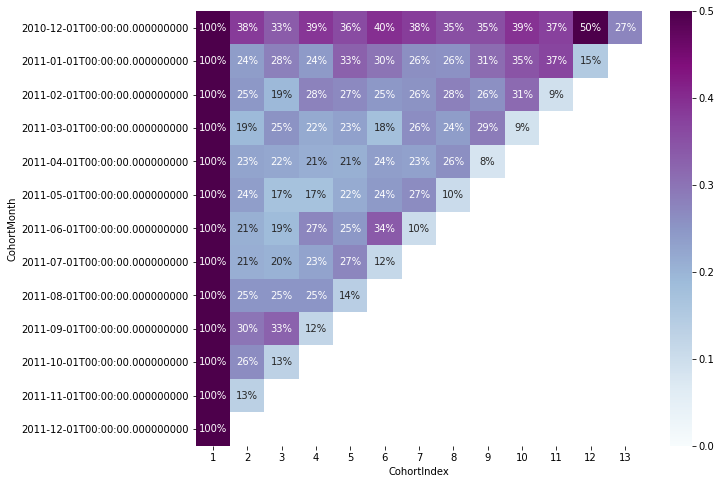

In [7]:
plt.figure(figsize=(10, 8))

sns.heatmap(data = retention_table,
            annot = True,        
            fmt = '.0%',         
            vmin = 0.0,          
            vmax = 0.5,           
            cmap = 'BuPu')
plt.show()

 ### RFM Segmentation:
 Here 'R', 'F', 'M' denote Recency, Frequency and Monetary analysis respectively.We will be sorting the customers into quartiles based on these three metrics, and calculating their RFM score. With the help of this score, we can effectively sort the customers into segments.
 
For our ease of analysis, we'll be moving forward assuming that the date of our RFM analysis is  just the day after the most recent invoice date in the dataset.

In [8]:
data_all= df.copy()

#calculating total the total amount for each line item (unit price * Quantity)
data_all['amount']= data_all['Quantity']* data_all['UnitPrice']
data_all.head()

#convert column to datetime
data_all['InvoiceDate']=pd.to_datetime(data_all['InvoiceDate'])

#setting date of analysis= 1 day after the most recent invoice
analysis_date = pd.to_datetime(data_all['InvoiceDate'].max())+ dt.timedelta(days=1)
data_all.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [9]:
#calculate the recency, frequency and Monetary values for each customer
grouped = data_all.groupby(['CustomerID'])\
                .agg({'InvoiceDate': lambda x: (analysis_date - x.max()).days,
                      'InvoiceNo': 'count',
                      'amount': 'sum'})\

#rename each column to denote the R,F,M Values
grouped.rename(columns = {'InvoiceDate': 'R_val',
                                   'InvoiceNo': 'F_val',
                                   'amount': 'M_val'}, inplace=True)
grouped.reset_index().head()

,CustomerID,R_val,F_val,M_val
0,12346.0,326,2,0.00
1,12347.0,2,182,4310.00
2,12348.0,75,31,1797.24
3,12349.0,19,73,1757.55
4,12350.0,310,17,334.40


In [10]:
r_quartiles = pd.qcut(grouped['R_val'], 4, labels = range(4, 0, -1))
grouped = grouped.assign(R_quartile = r_quartiles.values)

f_quartiles = pd.qcut(grouped['F_val'], 4, labels = range(1, 5, 1))
grouped = grouped.assign(F_quartile = f_quartiles.values)

m_quartiles = pd.qcut(grouped['M_val'], 4, labels = range(1, 5, 1))
grouped = grouped.assign(M_quartile = m_quartiles.values)

grouped=grouped
grouped

,R_val,F_val,M_val,R_quartile,F_quartile,M_quartile
CustomerID,,,,,,
12346.0,326,2,0.00,1,1,1
12347.0,2,182,4310.00,4,4,4
12348.0,75,31,1797.24,2,2,4
12349.0,19,73,1757.55,3,3,4
12350.0,310,17,334.40,1,1,2
...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1
18281.0,181,7,80.82,1,1,1
18282.0,8,13,176.60,4,1,1


In [11]:
def get_rfm_score(x):
    return str(x['R_quartile']) + str(x['F_quartile']) + str(x['M_quartile'])
grouped['RFM_Seg']= grouped.apply(get_rfm_score, axis=1)

grouped['RFM_Score']= grouped[['R_quartile','F_quartile','M_quartile']].sum(axis=1)
grouped.head()

,R_val,F_val,M_val,R_quartile,F_quartile,M_quartile,RFM_Seg,RFM_Score
CustomerID,,,,,,,,
12346.0,326,2,0.00,1,1,1,1.01.01.0,3
12347.0,2,182,4310.00,4,4,4,4.04.04.0,12
12348.0,75,31,1797.24,2,2,4,2.02.04.0,8
12349.0,19,73,1757.55,3,3,4,3.03.04.0,10
12350.0,310,17,334.40,1,1,2,1.01.02.0,4


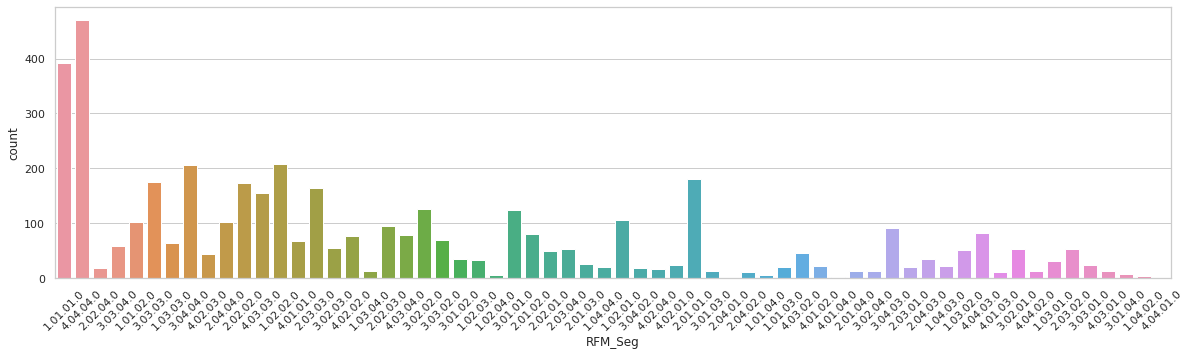

In [12]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 5))
sns.countplot(x="RFM_Seg", data=grouped)
plt.xticks(rotation=45)
plt.show()

<AxesSubplot:xlabel='R_val', ylabel='Density'>

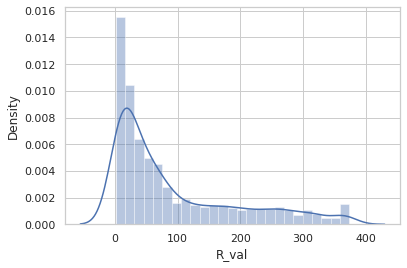

In [13]:
#plot the skewness of recency metric
sns.distplot(grouped['R_val'])

<AxesSubplot:xlabel='F_val', ylabel='Density'>

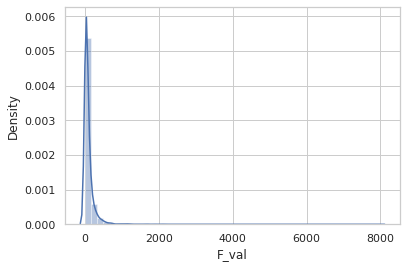

In [14]:
#plot the skewness of frequency metric
sns.distplot(grouped['F_val'])

<AxesSubplot:xlabel='M_val', ylabel='Density'>

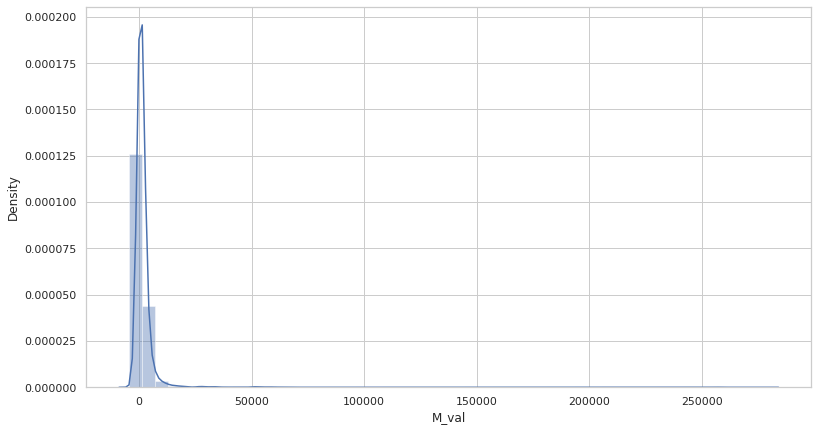

In [15]:
#plot the skewness of monetary metric
fig, ax = plt.subplots(figsize=(13, 7))
sns.distplot(grouped['M_val'])

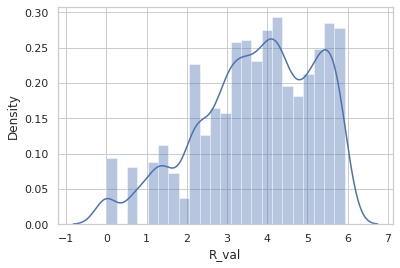

In [16]:
recency_log= np.log(grouped['R_val'])
sns.distplot(recency_log)
plt.show()

In [17]:
rfm = grouped[['R_val','F_val','M_val']]

#making all values in M_val positive
rfm['M_val']=rfm['M_val']+1

#applying logarithmic transformation
for c in ['R_val', 'F_val']:
    rfm[c]= np.log(rfm[c])
                       
#rfm_log=np.log(rfm[['R_val','F_val']])

#Normalization of variables
from sklearn.preprocessing import StandardScaler

ecomm_standardized= StandardScaler().fit_transform(rfm)

rfm[['R_val','F_val','M_val']]=ecomm_standardized.round(2)
'''rfm[rfm['M_val'].isna()]
rfm_log[rfm_log['M_val'].isna()]
rfm.loc[[12503, 12505, 12605,12666]]
#rfm_log.loc[[12503, 12505, 12605,12666]]
#rfm[rfm['CustomerID']==12503]'''
rfm

,R_val,F_val,M_val
CustomerID,,,
12346.0,1.40,-2.23,-0.23
12347.0,-2.08,1.13,0.29
12348.0,0.40,-0.19,-0.01
12349.0,-0.54,0.45,-0.02
12350.0,1.37,-0.63,-0.19
...,...,...,...
18280.0,1.29,-1.03,-0.21
18281.0,1.00,-1.30,-0.22
18282.0,-1.13,-0.83,-0.21


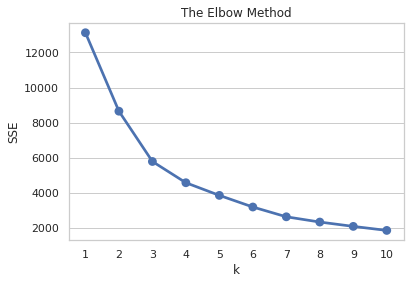

In [19]:
from sklearn.cluster import KMeans

#Fit KMeans and calculate SSE for each *k*
sse = {}

for k in range(1, 11):    
    kmeans = KMeans(n_clusters=k, random_state=1)    
    kmeans.fit(rfm)    
    sse[k] = kmeans.inertia_ 

    # sum of squared distances to closest cluster center
    # Plot SSE for each *k*
    
plt.title('The Elbow Method')
plt.xlabel('k'); 
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [22]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=1)    
kmeans.fit(rfm)


# Create a new DataFrame by adding a cluster label column to datamart_rfmt
grouped = grouped.assign(Cluster=kmeans.labels_)

# Group by cluster
clustered_data = grouped.groupby(['Cluster'])

# Calculate average RFMT values and segment sizes for each cluster
clustered_data.agg({
    'R_val': 'mean',
    'F_val': 'mean',
    'M_val': 'mean'
  }).round(2)

,R_val,F_val,M_val
Cluster,,,
0,147.61,28.23,567.25
1,7.67,1828.33,182181.98
2,21.07,170.74,3039.99
